# BERT Evaluation

## Package installation

In [62]:
# SETUP
! pip install -q -U tensorflow-text
! pip install -q tf-models-official

## Imports

In [63]:
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


tf.get_logger().setLevel('ERROR')

# For TPU
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [64]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


## Helpers

In [65]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return ' '.join(word for word in lemmatized)

def plot_loss(history, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('ACC')
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')

    ax3.plot(history.history['recall'])
    ax3.plot(history.history['val_recall'])
    ax3.set_title('Recall')
    ax3.set_ylabel('Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=1)
    ax3.legend(['Train', 'Validation'], loc='best')
    if title:
        fig.suptitle(title)
    plt.show()

def binary_metrics(y_test, y_pred):
    print('-'*80)
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('-'*80)
    
def get_metrics(y_test, X, model):

    y_prob = model.predict(X)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*80)
    print(f"acc: {acc*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print('-'*80)

    sns.heatmap(conf_matrix, annot=True, fmt="d");

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading datasets

### `politifacts`

In [66]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/politifact_scrap.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_P = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_P shape: {data_P.shape}")
print('-'*80)
print('-'*80)
print(data_P['category'].value_counts()/len(data_P)*100)
print('-'*80)
print(data_P['category2'].value_counts()/len(data_P)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_P shape: (19826, 8)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
1    71.562595
0    28.437405
Name: category, dtype: float64
--------------------------------------------------------------------------------
1    54.206597
0    45.793403
Name: category2, dtype: float64
--------------------------------------------------------------------------------


In [67]:
X_P = data_P['statement'].apply(clean).copy()
y_P = data_P['category2'].copy()

print('-'*80)
print(f"X_P shape: {X_P.shape}")
print(f"y_P shape: {y_P.shape}")
print('-'*80)
print(f"Original text: {data_P['statement'][0]}")
print(f"Clean text: {X_P[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_P shape: (19826,)
y_P shape: (19826,)
--------------------------------------------------------------------------------
Original text: “Washington public school forces unvaccinated teens to wear ankle monitors” as a condition of playing team sports.
Clean text: washington public school force unvaccinated teen wear ankle monitor condition playing team sport
--------------------------------------------------------------------------------


In [68]:
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_P_train shape: {X_P_train.shape}")
print(f"y_P_train shape: {y_P_train.shape}")
print('-'*80)
print(f"X_P_test shape: {X_P_test.shape}")
print(f"y_P_test shape: {y_P_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_P_train.sum()/len(y_P_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_P_test.sum()/len(y_P_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train shape: (15860,)
y_P_train shape: (15860,)
--------------------------------------------------------------------------------
X_P_test shape: (3966,)
y_P_test shape: (3966,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 54.300
Fake (1) proportion in test (%): 53.833
--------------------------------------------------------------------------------


### `FakeNewsNET`

In [69]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/FakesNewsNET.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_FNN = get_data_from_gcp(nrows=20000)

print('-'*80)
print(f"data_FNN shape: {data_FNN.shape}")
print('-'*80)

--------------------------------------------------------------------------------
data_FNN shape: (19281, 8)
--------------------------------------------------------------------------------


In [70]:
X_FNN = data_FNN['title'].apply(clean).copy()
y_FNN = data_FNN['category'].copy()

print('-'*80)
print(f"X_FNN shape: {X_FNN.shape}")
print(f"y_FNN shape: {y_FNN.shape}")
print('-'*80)
print(f"Original text: {data_FNN['title'][0]}")
print(f"Clean text: {X_FNN[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN shape: (19281,)
y_FNN shape: (19281,)
--------------------------------------------------------------------------------
Original text: Djou wins special election for Congress
Clean text: djou win special election congress
--------------------------------------------------------------------------------


In [71]:
X_FNN_train, X_FNN_test, y_FNN_train, y_FNN_test = train_test_split(X_FNN, y_FNN, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_FNN_train shape: {X_FNN_train.shape}")
print(f"y_FNN_train shape: {y_FNN_train.shape}")
print('-'*80)
print(f"X_FNN_test shape: {X_FNN_test.shape}")
print(f"y_FNN_test shape: {y_FNN_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_FNN_train.sum()/len(y_FNN_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_FNN_test.sum()/len(y_FNN_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train shape: (15424,)
y_FNN_train shape: (15424,)
--------------------------------------------------------------------------------
X_FNN_test shape: (3857,)
y_FNN_test shape: (3857,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 24.870
Fake (1) proportion in test (%): 23.568
--------------------------------------------------------------------------------


### `Bisaillon`

In [72]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


In [73]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


In [74]:
true['category'] = 0
fake['category'] = 1

data_BIS = pd.concat([true, fake]).reset_index(drop=True)

print('-'*80)
print(f"data_BIS shape: {data_BIS.shape}")
print('-'*80)
print(f"ratio #true: {len(data_BIS[data_BIS['category']==0])/len(data_BIS)*100:.2f}%")
print(f"ratio #fake: {len(data_BIS[data_BIS['category']==1])/len(data_BIS)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data_BIS shape: (44689, 5)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


In [75]:
X_BIS = data_BIS['title'].apply(clean).copy()
y_BIS = data_BIS['category'].copy()

print('-'*80)
print(f"X_BIS shape: {X_BIS.shape}")
print(f"y_BIS shape: {y_BIS.shape}")
print('-'*80)
print(f"Original text: {data_BIS['title'][0]}")
print(f"Clean text: {X_BIS[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS shape: (44689,)
y_BIS shape: (44689,)
--------------------------------------------------------------------------------
Original text: As U.S. budget fight looms, Republicans flip their fiscal script
Clean text: u budget fight loom republican flip fiscal script
--------------------------------------------------------------------------------


In [76]:
X_BIS_train, X_BIS_test, y_BIS_train, y_BIS_test = train_test_split(X_BIS, y_BIS, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_BIS_train shape: {X_BIS_train.shape}")
print(f"y_BIS_train shape: {y_BIS_train.shape}")
print('-'*80)
print(f"X_BIS_test shape: {X_BIS_test.shape}")
print(f"y_BIS_test shape: {y_BIS_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_BIS_train.sum()/len(y_BIS_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_BIS_test.sum()/len(y_BIS_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train shape: (35751,)
y_BIS_train shape: (35751,)
--------------------------------------------------------------------------------
X_BIS_test shape: (8938,)
y_BIS_test shape: (8938,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 52.670
Fake (1) proportion in test (%): 52.003
--------------------------------------------------------------------------------


### `Poynter`

In [77]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/poynter_final_condensed.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_PO = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_PO shape: {data_PO.shape}")
print('-'*80)
print('-'*80)
print(data_PO['label_list_transformed'].value_counts()/len(data_PO)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_PO shape: (14897, 3)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
0.0    50.063771
1.0    49.936229
Name: label_list_transformed, dtype: float64
--------------------------------------------------------------------------------


In [78]:
X_PO = data_PO['title_list'].apply(clean).copy()
y_PO = data_PO['label_list_transformed'].copy()

print('-'*80)
print(f"X_PO shape: {X_PO.shape}")
print(f"y_PO shape: {y_PO.shape}")
print('-'*80)
print(f"Original text: {data_PO['title_list'][0]}")
print(f"Clean text: {X_PO[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO shape: (14897,)
y_PO shape: (14897,)
--------------------------------------------------------------------------------
Original text: There is a call for free vaccination in the Ciudad de la Luz center, in Alicante, for people over 12 years old.
Clean text: call free vaccination ciudad de la luz center alicante people year old
--------------------------------------------------------------------------------


In [79]:
X_PO_train, X_PO_test, y_PO_train, y_PO_test = train_test_split(X_PO, y_PO, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_PO_train shape: {X_PO_train.shape}")
print(f"y_PO_train shape: {y_PO_train.shape}")
print('-'*80)
print(f"X_PO_test shape: {X_PO_test.shape}")
print(f"y_PO_test shape: {y_PO_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_PO_train.sum()/len(y_PO_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_PO_test.sum()/len(y_PO_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO_train shape: (11917,)
y_PO_train shape: (11917,)
--------------------------------------------------------------------------------
X_PO_test shape: (2980,)
y_PO_test shape: (2980,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 49.870
Fake (1) proportion in test (%): 50.201
--------------------------------------------------------------------------------


### `Alll`

In [80]:
X_ALLL_train = pd.concat([X_P_train, X_FNN_train, X_BIS_train, X_PO_train]).sample(frac=1, random_state=42).reset_index(drop=True)
y_ALLL_train = pd.concat([y_P_train, y_FNN_train, y_BIS_train, y_PO_train]).sample(frac=1, random_state=42).reset_index(drop=True)

X_ALLL_test = pd.concat([X_P_test, X_FNN_test, X_BIS_test, X_PO_test]).sample(frac=1, random_state=42).reset_index(drop=True)
y_ALLL_test = pd.concat([y_P_test, y_FNN_test, y_BIS_test, y_PO_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print('-'*80)
print(f"X_ALLL_train shape: {X_ALLL_train.shape}")
print(f"y_ALLL_train shape: {y_ALLL_train.shape}")
print('-'*80)
print(f"X_ALLL_test shape: {X_ALLL_test.shape}")
print(f"y_ALLL_test shape: {y_ALLL_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_ALLL_train.sum()/len(y_ALLL_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_ALLL_test.sum()/len(y_ALLL_test)*100:.3f}")
print('-'*80)
print('### TRAIN ###')
print('-'*80)
print(f"Politifact ratio: {X_P_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print(f"FakeNewsNET ratio: {X_FNN_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print(f"Bisaillon ratio: {X_BIS_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print(f"Poynter ratio: {X_PO_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print('-'*80)
print('### TEST ###')
print('-'*80)
print(f"Politifact ratio: {X_P_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print(f"FakeNewsNET ratio: {X_FNN_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print(f"Bisaillon ratio: {X_BIS_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print(f"Poynter ratio: {X_PO_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALLL_train shape: (78952,)
y_ALLL_train shape: (78952,)
--------------------------------------------------------------------------------
X_ALLL_test shape: (19741,)
y_ALLL_test shape: (19741,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 47.144
Fake (1) proportion in test (%): 46.543
--------------------------------------------------------------------------------
### TRAIN ###
--------------------------------------------------------------------------------
Politifact ratio: 0.20
FakeNewsNET ratio: 0.20
Bisaillon ratio: 0.45
Poynter ratio: 0.15
--------------------------------------------------------------------------------
### TEST ###
--------------------------------------------------------------------------------
Politifact ratio: 0.20
FakeNewsNET ratio:

## BERT

### Models available

In [81]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Preprocessing

In [83]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [84]:
# text_test = ['this is such an amazing movie!']
# text_test = [X_P_train.iloc[0], X_P_train.iloc[1]]
text_test = X_ALLL_train.values[:2]
text_preprocessed = bert_preprocess_model(text_test)

print(f'text:      : {text_test}')
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

text:      : ['arya stark'
 'ace cake star duff goldman show dramatic month weight loss see pic']
Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (2, 128)
Word Ids   : [  101 26140  9762   102     0     0     0     0     0     0     0     0]
Input Mask : [1 1 1 1 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### Model

In [85]:
bert_model = hub.KerasLayer(tfhub_handle_encoder, trainable=False)

In [86]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(2, 512)
Pooled Outputs Values:[ 0.9258886   0.2689409  -0.10497021 -0.05306906 -0.1854622   0.96313626
  0.9866986  -0.5534941  -0.19742405 -0.99939877 -0.13812444 -0.9875875 ]
Sequence Outputs Shape:(2, 128, 512)
Sequence Outputs Values:[[-0.43011934 -0.2032088   0.3624037  ... -1.5511746   0.6652816
  -0.22219995]
 [-0.08298272 -0.3450057   0.07558873 ... -1.4381343   0.739169
  -0.04469866]
 [-0.45170254 -0.020377   -0.11131793 ... -1.5348899   0.74589616
  -0.4154957 ]
 ...
 [ 0.30835128 -0.26980075 -0.15429333 ... -0.9528643   0.58467984
   0.02994817]
 [ 0.27763027 -0.198476   -0.16987798 ... -0.89286315  0.6930533
   0.04731674]
 [ 0.07620674  0.07966904  0.02676088 ... -0.92250365  0.5963318
  -0.04765435]]


In [88]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

loss = tf.keras.losses.BinaryCrossentropy()

epochs = 5
# steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
steps_per_epoch = len(X_P_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

def init_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    
    model = tf.keras.Model(text_input, net)
    
    model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

    return model

In [89]:
# Check
classifier_model = init_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor(
[[0.2570055 ]
 [0.24296913]], shape=(2, 1), dtype=float32)


In [90]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)

print(f'Training model with {tfhub_handle_encoder}')

classifier_model = init_model()

history = classifier_model.fit(X_ALLL_train, 
                  y_ALLL_train,
                  validation_split=0.2,
                  batch_size=128,
                  epochs=10,
                  callbacks=[es],
                  verbose=1)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
494/494 [==============================] - 1064s 2s/step - loss: 0.6612 - accuracy: 0.5985 - precision: 0.5756 - recall: 0.5644 - val_loss: 0.5735 - val_accuracy: 0.6891 - val_precision: 0.7096 - val_recall: 0.5773
Epoch 2/10
494/494 [==============================] - 1047s 2s/step - loss: 0.5498 - accuracy: 0.7092 - precision: 0.7079 - recall: 0.6520 - val_loss: 0.4859 - val_accuracy: 0.7596 - val_precision: 0.7643 - val_recall: 0.7091
Epoch 3/10
494/494 [==============================] - 1055s 2s/step - loss: 0.4838 - accuracy: 0.7584 - precision: 0.7604 - recall: 0.7115 - val_loss: 0.4419 - val_accuracy: 0.7842 - val_precision: 0.8207 - val_recall: 0.6943
Epoch 4/10
494/494 [==============================] - 1056s 2s/step - loss: 0.4378 - accuracy: 0.7868 - precision: 0.7888 - recall: 0.7480 - val_loss: 0.4060 - val_accuracy: 0.8081 - val_precision: 0.8051 - val_recall: 0.7827
Epoc

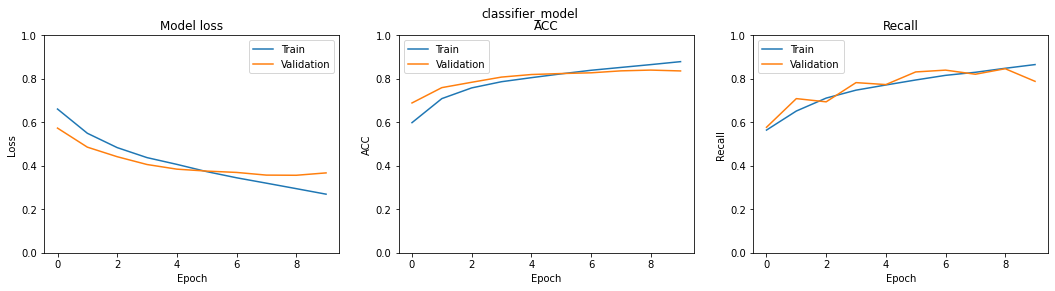

In [92]:
plot_loss(history, title='classifier_model')

--------------------------------------------------------------------------------
acc: 83.99%
recall: 79.59%
precision: 85.05%
f1: 82.23%
--------------------------------------------------------------------------------


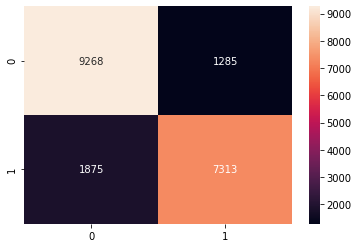

In [94]:
get_metrics(y_ALLL_test, X_ALLL_test, classifier_model)

--------------------------------------------------------------------------------
acc: 61.70%
recall: 60.05%
precision: 65.81%
f1: 62.80%
--------------------------------------------------------------------------------


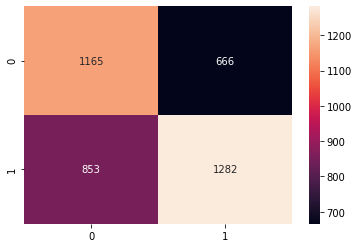

In [95]:
get_metrics(y_P_test, X_P_test, classifier_model)

--------------------------------------------------------------------------------
acc: 81.75%
recall: 54.57%
precision: 63.02%
f1: 58.49%
--------------------------------------------------------------------------------


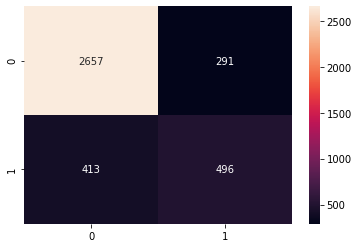

In [96]:
get_metrics(y_FNN_test, X_FNN_test, classifier_model)

--------------------------------------------------------------------------------
acc: 94.82%
recall: 92.84%
precision: 97.08%
f1: 94.91%
--------------------------------------------------------------------------------


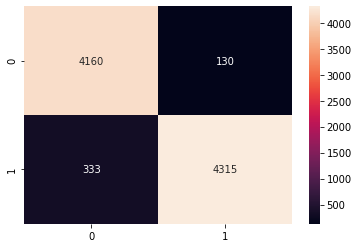

In [97]:
get_metrics(y_BIS_test, X_BIS_test, classifier_model)

--------------------------------------------------------------------------------
acc: 84.09%
recall: 81.55%
precision: 86.04%
f1: 83.73%
--------------------------------------------------------------------------------


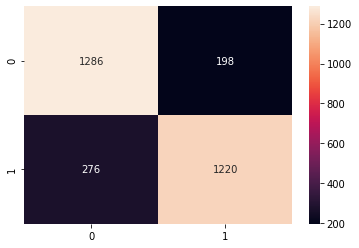

In [98]:
get_metrics(y_PO_test, X_PO_test, classifier_model)

In [91]:
# classifier_model.save(saved_model_path, include_optimizer=False)

# Colab
model_name = 'ALLL_BERT_model'

# Notebook
# model_name = '../raw_data/ALLL_BERT_model'

classifier_model.save(model_name)

UnimplementedError: ignored

In [ ]:
# dataset_name = 'imdb'
# saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

# classifier_model.save(saved_model_path, include_optimizer=False)

# Colab
model_name = 'P_BERT_model'

# Notebook
# model_name = '../raw_data/P_BERT_model'

classifier_model.save(model_name)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)